<a href="https://colab.research.google.com/github/Akshatpattiwar512/Recurrent-Neural-Network/blob/main/Reber_Grammar_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [1]:
default_reber_grammar=[
    [("B",1)],  #(state 0) =B=> (state 1)
    [("T", 2),("P", 3)],  # (state 1) =T=> (state 2) or =P=> (state 3)
    [("X", 5), ("S", 2)], # (state 2) =X=> (state 5) or =S=> (state 2)
    [("T", 3), ("V", 4)], # (state 3) =T=> (state 3) or =V=> (state 4)
    [("V", 6), ("P", 5)], # (state 4) =V=> (state 6) or =P=> (state 5)
    [("X",3), ("S", 6)],  # (state 5) =X=> (state 3) or =S=> (state 6)
    [("E", None)]         # (state 6) =E=> <EOS>
    
]

In [2]:
embedded_reber_grammar=[
    [("B",1)],  #(state 0) =B=> (state 1)
    [("T", 2),("P", 3)],  # (state 1) =T=> (state 2) or =P=> (state 3)
    [(default_reber_grammar,4)], # (state 2) =REBER=> (state 4)
    [(default_reber_grammar,5)], # (state 3) =REBER=> (state 5)
    [("P", 6)], # (state 4) =P=> (state 6)
    [("T",6)],  # (state 5) =T=> (state 3)
    [("E", None)]         # (state 6) =E=> <EOS>
    
]

## Data generation
 

In [3]:
def generate_valid_string(grammar):
    state = 0
    output = []
    while state is not None:
        char, state = grammar[state][np.random.randint(len(grammar[state]))]
        if isinstance(char, list):  # embedded reber
            char = generate_valid_string(char)
        output.append(char)
    return "".join(output)

In [4]:
def generate_corrupted_string(grammar, chars='BTSXPVE'):
    '''Substitute one character to violate the grammar'''
    good_string = generate_valid_string(grammar)
    idx = np.random.randint(len(good_string))
    good_char = good_string[idx]
    bad_char = np.random.choice(sorted(set(chars)-set(good_char)))
    return good_string[:idx]+bad_char+good_string[idx+1:]

In [5]:
chars='BTSXPVE'
chars_dict = {a:i for i,a in enumerate(chars)}
chars_dict

{'B': 0, 'E': 6, 'P': 4, 'S': 2, 'T': 1, 'V': 5, 'X': 3}

In [6]:
def str2onehot(string, num_steps=12, chars_dict=chars_dict):
    res = np.zeros((num_steps, len(chars_dict)))
    for i in range(min(len(string), num_steps)):
        c = string[i]
        res[i][chars_dict[c]] = 1
    return res

In [7]:
def generate_data(data_size=10000, grammar=embedded_reber_grammar, num_steps=None):
    good = [generate_valid_string(grammar) for _ in range(data_size//2)]
    bad = [generate_corrupted_string(grammar) for _ in range(data_size//2)]
    all_strings = good+bad
    if num_steps is None:
        num_steps = max([len(s) for s in all_strings])
    X = np.array([str2onehot(s) for s in all_strings])
    l = np.array([len(s) for s in all_strings])
    y = np.concatenate((np.ones(len(good)), np.zeros((len(bad))))).reshape(-1, 1)
    idx = np.random.permutation(data_size)
    return X[idx], l[idx], y[idx]

In [10]:
np.random.seed(42)
X_train, seq_lens_train, y_train = generate_data(10000)
X_val, seq_lens_val, y_val = generate_data(5000)
X_train.shape, X_val.shape

((10000, 12, 7), (5000, 12, 7))

## Model building

In [17]:
x = keras.layers.Input(shape=(12, 7)) # we define our input's shape
# first we define our RNN cells to use in the RNN model
# let's keep the model simple ...
cell = keras.layers.SimpleRNNCell(4, activation='tanh')  # ... by just using 4 units (like 4 units in hidden layers)
rnn = keras.layers.RNN(cell)
rnn_output = rnn(x)

In [19]:
output = keras.layers.Dense(units=1, activation='sigmoid')(rnn_output)

In [20]:
# let's compile the model
model = keras.Model(inputs=x, outputs=output)
# loss is binary cropss entropy since this is a binary classification task
# and evaluation metric as f1
model.compile(loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 12, 7)]           0         
_________________________________________________________________
rnn (RNN)                    (None, 4)                 48        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 53
Trainable params: 53
Non-trainable params: 0
_________________________________________________________________


In [21]:
# we train the model for 100 epochs
# verbose level 2 displays more info while trianing
H = model.fit(X_train, y_train, epochs=100, verbose=2, validation_data=(X_val, y_val))

Epoch 1/100
313/313 - 3s - loss: 0.7015 - accuracy: 0.5065 - val_loss: 0.6963 - val_accuracy: 0.5046
Epoch 2/100
313/313 - 1s - loss: 0.6873 - accuracy: 0.5419 - val_loss: 0.6822 - val_accuracy: 0.5884
Epoch 3/100
313/313 - 1s - loss: 0.6687 - accuracy: 0.6124 - val_loss: 0.6534 - val_accuracy: 0.6326
Epoch 4/100
313/313 - 1s - loss: 0.6372 - accuracy: 0.6568 - val_loss: 0.6195 - val_accuracy: 0.6794
Epoch 5/100
313/313 - 1s - loss: 0.6087 - accuracy: 0.6893 - val_loss: 0.5949 - val_accuracy: 0.7156
Epoch 6/100
313/313 - 1s - loss: 0.5853 - accuracy: 0.7173 - val_loss: 0.5699 - val_accuracy: 0.7320
Epoch 7/100
313/313 - 1s - loss: 0.5639 - accuracy: 0.7324 - val_loss: 0.5499 - val_accuracy: 0.7596
Epoch 8/100
313/313 - 1s - loss: 0.5485 - accuracy: 0.7477 - val_loss: 0.5364 - val_accuracy: 0.7654
Epoch 9/100
313/313 - 1s - loss: 0.5346 - accuracy: 0.7555 - val_loss: 0.5262 - val_accuracy: 0.7550
Epoch 10/100
313/313 - 1s - loss: 0.5214 - accuracy: 0.7626 - val_loss: 0.5108 - val_accura

In [22]:
def plot_results(H):
    results = pd.DataFrame({"Train Loss": H.history['loss'], "Validation Loss": H.history['val_loss'],
              "Train Accuracy": H.history['accuracy'], "Validation Accuracy": H.history['val_accuracy']
             })
    fig, ax = plt.subplots(nrows=2, figsize=(16, 9))
    results[["Train Loss", "Validation Loss"]].plot(ax=ax[0])
    results[["Train Accuracy", "Validation Accuracy"]].plot(ax=ax[1])
    ax[0].set_xlabel("Epoch")
    ax[1].set_xlabel("Epoch")
    plt.show()

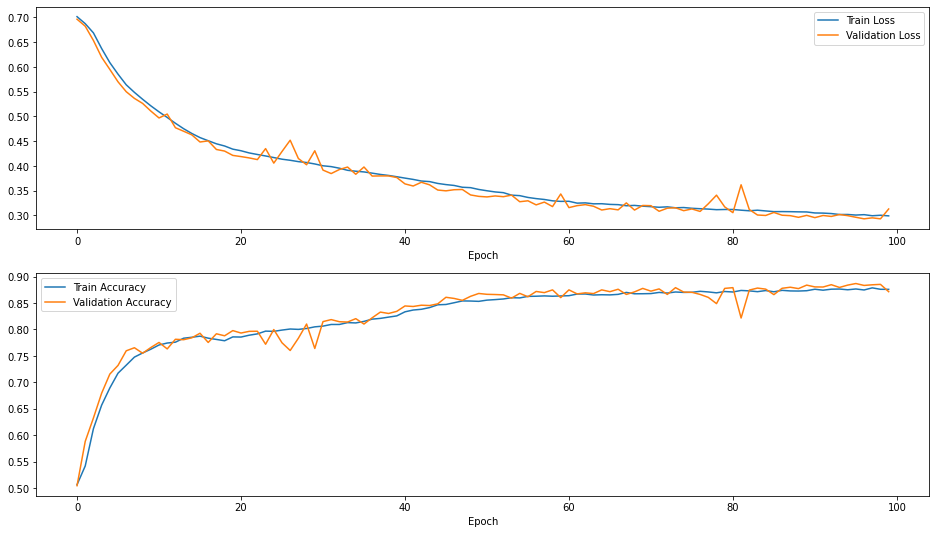

In [27]:
plot_results(H)